In [1]:
#compares 1995-2014 EC-Earth model to 1995-2014 ERA5 Reanalysis
#compares 1995-2014 EC-Earth to 1850-1900 (pre industrial) EC-Earth
#based on monhtly mean data

##IMPORT PACKAGES

import cartopy.feature as cfeature ## for lakes/borders et
countries_50m = cfeature.NaturalEarthFeature('cultural','admin_0_countries','50m',edgecolor='k',facecolor='none')
import cartopy.crs as ccrs
import numpy as np
from netCDF4 import Dataset  
import matplotlib.pyplot as plt
import math
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cf_units as unit
import matplotlib.gridspec as gridspec

import iris
from iris.experimental.equalise_cubes import equalise_attributes
from iris.util import unify_time_units
import iris.coord_categorisation
import iris.plot as iplt
import iris.quickplot as qplt
import pandas as pd

import glob
import datetime as dt

from scipy.stats import norm

crs = ccrs.PlateCarree()

##define constants
p0 = 1000   #base pressure level
rcp = 0.286 #gas constant divided by specific heat capacity
R_gas= 8.31 #ideal gas constant
G = 9.81 #gravity

#make function to convert all floats to integers in a matrix
def f1(x):
    return np.int(x)
f2 = np.vectorize(f1)

/apps/developers/compilers/canopy3/2.1.3/1/bit-64/Canopy/edm/envs/User/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
##Read in geopotential data

ncT = Dataset("/nfs/annie/ee21pnm/monthly_t2m.nc","r")

#information on the file's variables
#print(ncT.variables.keys())
#for var in ['longitude', 'latitude', 'time', 't2m']:
#    print(var,ncT.variables[var])
    
#time1 = ncT.variables['time'][:]
#time = [float(t) for t in time]

# Convert all the times in the file to datetime objects
#dt_time = [dt.date(1900, 1, 1) + dt.timedelta(hours=t) for t in time]

#convert to array
#dt_time2 = np.array(dt_time)

#print(dt_time2)


In [3]:
#"/nfs/annie/earamay/Prash/historical/tas/tas_day_EC-Earth3_historical_r10i1p1f1_gr_19080101-19081231.nc"
##Read in geopotential data

ncT = Dataset("/nfs/annie/earamay/Prash/historical/tas/tas_day_EC-Earth3_historical_r1i1p1f1_gr_20140101-20141231.nc","r")

#information on the file's variables
#print(ncT.variables.keys())
for var in ['lon', 'lat', 'time', 'tas']:
    print(var,ncT.variables[var])


time = ncT.variables['time'][:]
tas = ncT.variables['tas'][:]



lon <class 'netCDF4._netCDF4.Variable'>
float64 lon(lon)
    bounds: lon_bnds
    units: degrees_east
    axis: X
    long_name: Longitude
    standard_name: longitude
unlimited dimensions: 
current shape = (512,)
filling on, default _FillValue of 9.969209968386869e+36 used

lat <class 'netCDF4._netCDF4.Variable'>
float64 lat(lat)
    bounds: lat_bnds
    units: degrees_north
    axis: Y
    long_name: Latitude
    standard_name: latitude
unlimited dimensions: 
current shape = (256,)
filling on, default _FillValue of 9.969209968386869e+36 used

time <class 'netCDF4._netCDF4.Variable'>
float64 time(time)
    bounds: time_bnds
    units: days since 1850-01-01 00:00:00
    calendar: proleptic_gregorian
    axis: T
    long_name: time
    standard_name: time
unlimited dimensions: time
current shape = (365,)
filling on, default _FillValue of 9.969209968386869e+36 used

tas <class 'netCDF4._netCDF4.Variable'>
float32 tas(time, lat, lon)
    standard_name: air_temperature
    long_name: Near-

In [4]:
#PNW Reanalysis

lat_min =45
lat_max = 51
lon_min = -126+360
lon_max = -119+360

#create empty lists
months =[]
mean_temps =[]

##IRIS - from Cathyrn Birch
import warnings
warnings.filterwarnings("ignore")

cube1 = iris.load_cube("/nfs/annie/ee21pnm/monthly_t2m.nc")

iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

# Access the longitude and latitude coordinates
longitude = cube1.coord('longitude')
latitude = cube1.coord('latitude')
time = cube1.coord('time')
month = cube1.coord('month')

#print(np.nanmin(longitude.points), np.nanmax(longitude.points))
#print(np.nanmin(latitude.points), np.nanmax(latitude.points))

#concatenate files into one
#equalise_attributes(cube_list) 
    # iris requires metadata be the same to concatenate into one cube. 
    # This function in conjunction with unify_time_units from iris.util will solve most issues 
    # but you may have to check things manually if it doesn't fix everything (shouldn't be an issue for this exercise).
#unify_time_units(cube_list)  
#mod_cube = cube_list.concatenate_cube()
#print(mod_cube) 

# Functions to identify latitudes and longitudes we want to subset to
def region_lat(input):
    return lat_min  <= input <= lat_max 

def region_long(input):
    return lon_min  <= input <= lon_max 

region_con = iris.Constraint(latitude = region_lat, longitude = region_long)

# Subset the cube to the location of interest
region_subset = cube1.extract(region_con)

#convert units
region_subset.convert_units('celsius')

for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:

    mon_constraint = iris.Constraint(month=mon)

    #find spatial average for each month
    coords = ('longitude', 'latitude')
    # Subset the cube to the location of interest
    mon_subset = region_subset.extract(mon_constraint)

    spatial_mean = mon_subset.collapsed(coords, iris.analysis.MEAN)

    #find overall mean by month
    result = spatial_mean.collapsed('time', iris.analysis.MEAN)
    #print('Date: '+mon+'-'+str(year)+' Max Temp:', result.data)

    months.append(mon)
    mean_temps.append(result.data)

#make dataframe
df_PNWR = pd.DataFrame(mean_temps, index=[months], columns=['Mean_Temp'])

df_PNWR

,Mean_Temp
1,0.767366
2,1.738268
3,3.623865
4,6.211481
5,9.818180
6,12.970092
7,16.485602
8,16.336439
9,13.484015
10,8.156879


In [5]:
#Siberia Reanalysis

lat_min =65
lat_max = 70
lon_min = 130
lon_max = 137

#create empty lists
months =[]
mean_temps =[]

##IRIS - from Cathyrn Birch
import warnings
warnings.filterwarnings("ignore")

cube1 = iris.load_cube("/nfs/annie/ee21pnm/monthly_t2m.nc")

iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

# Access the longitude and latitude coordinates
longitude = cube1.coord('longitude')
latitude = cube1.coord('latitude')
time = cube1.coord('time')
month = cube1.coord('month')

#print(np.nanmin(longitude.points), np.nanmax(longitude.points))
#print(np.nanmin(latitude.points), np.nanmax(latitude.points))

#concatenate files into one
#equalise_attributes(cube_list) 
    # iris requires metadata be the same to concatenate into one cube. 
    # This function in conjunction with unify_time_units from iris.util will solve most issues 
    # but you may have to check things manually if it doesn't fix everything (shouldn't be an issue for this exercise).
#unify_time_units(cube_list)  
#mod_cube = cube_list.concatenate_cube()
#print(mod_cube) 

# Functions to identify latitudes and longitudes we want to subset to
def region_lat(input):
    return lat_min  <= input <= lat_max 

def region_long(input):
    return lon_min  <= input <= lon_max 

region_con = iris.Constraint(latitude = region_lat, longitude = region_long)

# Subset the cube to the location of interest
region_subset = cube1.extract(region_con)

#convert units
region_subset.convert_units('celsius')

for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:

    mon_constraint = iris.Constraint(month=mon)

    #find spatial average for each month
    coords = ('longitude', 'latitude')
    # Subset the cube to the location of interest
    mon_subset = region_subset.extract(mon_constraint)

    spatial_mean = mon_subset.collapsed(coords, iris.analysis.MEAN)

    #find overall mean by month
    result = spatial_mean.collapsed('time', iris.analysis.MEAN)
    #print('Date: '+mon+'-'+str(year)+' Max Temp:', result.data)

    months.append(mon)
    mean_temps.append(result.data)

#make dataframe
df_SIBR = pd.DataFrame(mean_temps, index=[months], columns=['Mean_Temp'])

df_SIBR

,Mean_Temp
1,-38.323529
2,-36.576869
3,-25.741260
4,-12.119565
5,0.376584
6,10.555007
7,13.938986
8,10.209088
9,0.673015
10,-13.969323


In [6]:
#PNW Model

#r[1,2,3,4,6,7,9,10,12,14]i1p1f1

#specify variable
tas_constraint = iris.Constraint(cube_func=lambda cube: cube.var_name == 'tas')

#create empty lists
months =[]
mean_temps =[]
member =[]
years=[]

#lat long boundary
lat_min1 =45
lat_max1=51
lon_min1 = -126+360
lon_max1 = -119+360

path = '/nfs/annie/earamay/Prash/historical/tas/'
#tas_Amon_EC-Earth3_historical_r12i1p1f1_gr_185001-185012.nc

for memberno in [1,2,3,4,6,7,9,10,12,14]:
#for memberno in [1]:
#for memberno in [10,12,14]:
    for year in np.arange(1995,2015,1):
        #files = glob.glob("/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        files = glob.glob(path + "tas_Amon_EC-Earth3_historical_r" +str(memberno)+ "i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        #files = glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc")
        for filename in files:
            #for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
                
            member_string = "r" +str(memberno)+ "i1p1f1"

            cube1 = iris.load_cube(filename)

            iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

            # Access the longitude and latitude coordinates
            longitude = cube1.coord('longitude')
            latitude = cube1.coord('latitude')
            time = cube1.coord('time')
            month = cube1.coord('month')

            # Functions to identify latitudes and longitudes we want to subset to
            def region_lat(input):
                return lat_min1  <= input <= lat_max1 

            def region_long(input):
                return lon_min1  <= input <= lon_max1 


            def time_convert(input):
                return unit.num2date(input,'days since 1850-01-01 00:00:00', 'proleptic_gregorian')
            
            #constraints
            region_con = iris.Constraint(latitude = region_lat, longitude = region_long)
            region_subset = cube1.extract(region_con)
            #convert units
            region_subset.convert_units('celsius')
            
            coords = ('longitude', 'latitude')
            spatial_mean = region_subset.collapsed(coords, iris.analysis.MEAN)

            #append time and max temps to lists
            months.extend(spatial_mean.coord('month').points)
            mean_temps.extend(spatial_mean.data)
            
            add_to_years = np.repeat(year,np.shape(spatial_mean))
            add_to_member = np.repeat(member_string,np.shape(spatial_mean))
            member.extend(add_to_member)
            years.extend(add_to_years)

#make dataframe
df = pd.DataFrame({
    'Month': months,
    'Year': years,
    'Mean_Temp': mean_temps,
    'Member': member,
})

df['Mean_Temp'] = df['Mean_Temp'].astype(float)
df_PNWE = df.groupby('Month')['Mean_Temp'].mean()
df_PNWE


Month
1     -2.254773
2     -0.009797
3      2.673852
4      5.796739
5      9.603735
6     13.874069
7     17.050964
8     18.263931
9     14.798904
10     8.819552
11     2.548695
12    -1.804536
Name: Mean_Temp, dtype: float64

In [7]:
#Siberia Model

#r[1,2,3,4,6,7,9,10,12,14]i1p1f1

#specify variable
tas_constraint = iris.Constraint(cube_func=lambda cube: cube.var_name == 'tas')

#create empty lists
months =[]
mean_temps =[]
member =[]
years=[]

#lat long boundary
lat_min1 =65
lat_max1 = 70
lon_min1 = 130
lon_max1 = 137

path = '/nfs/annie/earamay/Prash/historical/tas/'
#tas_Amon_EC-Earth3_historical_r12i1p1f1_gr_185001-185012.nc

for memberno in [1,2,3,4,6,7,9,10,12,14]:
#for memberno in [1]:
#for memberno in [10,12,14]:
    for year in np.arange(1995,2015,1):
        #files = glob.glob("/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        files = glob.glob(path + "tas_Amon_EC-Earth3_historical_r" +str(memberno)+ "i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        #files = glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc")
        for filename in files:
            #for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
                
            member_string = "r" +str(memberno)+ "i1p1f1"

            cube1 = iris.load_cube(filename)

            iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

            # Access the longitude and latitude coordinates
            longitude = cube1.coord('longitude')
            latitude = cube1.coord('latitude')
            time = cube1.coord('time')
            month = cube1.coord('month')

            # Functions to identify latitudes and longitudes we want to subset to
            def region_lat(input):
                return lat_min1  <= input <= lat_max1 

            def region_long(input):
                return lon_min1  <= input <= lon_max1 


            def time_convert(input):
                return unit.num2date(input,'days since 1850-01-01 00:00:00', 'proleptic_gregorian')
            
            #constraints
            region_con = iris.Constraint(latitude = region_lat, longitude = region_long)
            region_subset = cube1.extract(region_con)
            #convert units
            region_subset.convert_units('celsius')
            
            coords = ('longitude', 'latitude')
            spatial_mean = region_subset.collapsed(coords, iris.analysis.MEAN)

            #append time and max temps to lists
            months.extend(spatial_mean.coord('month').points)
            mean_temps.extend(spatial_mean.data)
            
            add_to_years = np.repeat(year,np.shape(spatial_mean))
            add_to_member = np.repeat(member_string,np.shape(spatial_mean))
            member.extend(add_to_member)
            years.extend(add_to_years)

#make dataframe
df = pd.DataFrame({
    'Month': months,
    'Year': years,
    'Mean_Temp': mean_temps,
    'Member': member,
})

df['Mean_Temp'] = df['Mean_Temp'].astype(float)
df_SIBE = df.groupby('Month')['Mean_Temp'].mean()
df_SIBE

Month
1    -33.523738
2    -31.431197
3    -23.753681
4    -13.979893
5     -5.656501
6      6.234004
7     11.570367
8      8.417486
9      0.139601
10   -16.080746
11   -27.779673
12   -32.434886
Name: Mean_Temp, dtype: float64

In [6]:
#PNW 1850-1900

#specify variable
tas_constraint = iris.Constraint(cube_func=lambda cube: cube.var_name == 'tas')

#create empty lists
months =[]
mean_temps =[]
member =[]
years=[]

#lat long boundary
lat_min1 =45
lat_max1=51
lon_min1 = -126+360
lon_max1 = -119+360

path = '/nfs/annie/earamay/Prash/historical/tas/'
#"/nfs/annie/earamay/Prash/historical/tas/tas_day_EC-Earth3_historical_r10i1p1f1_gr_19080101-19081231.nc"

for memberno in [1,2,3,4,6,7,9,10,12,14]:
#for memberno in [1]:
#for memberno in [10,12,14]:
    for year in np.arange(1850,1901,1):
        #files = glob.glob("/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        files = glob.glob(path + "tas_Amon_EC-Earth3_historical_r" +str(memberno)+ "i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        #files = glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc")
        for filename in files:
            #for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
                
            member_string = "r" +str(memberno)+ "i1p1f1"

            cube1 = iris.load_cube(filename)

            iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

            # Access the longitude and latitude coordinates
            longitude = cube1.coord('longitude')
            latitude = cube1.coord('latitude')
            time = cube1.coord('time')
            month = cube1.coord('month')

            # Functions to identify latitudes and longitudes we want to subset to
            def region_lat(input):
                return lat_min1  <= input <= lat_max1 

            def region_long(input):
                return lon_min1  <= input <= lon_max1 


            def time_convert(input):
                return unit.num2date(input,'days since 1850-01-01 00:00:00', 'proleptic_gregorian')
            
            #constraints
            region_con = iris.Constraint(latitude = region_lat, longitude = region_long)
            region_subset = cube1.extract(region_con)
            #convert units
            region_subset.convert_units('celsius')
            
            coords = ('longitude', 'latitude')
            spatial_mean = region_subset.collapsed(coords, iris.analysis.MEAN)

            #append time and max temps to lists
            months.extend(spatial_mean.coord('month').points)
            mean_temps.extend(spatial_mean.data)
            
            add_to_years = np.repeat(year,np.shape(spatial_mean))
            add_to_member = np.repeat(member_string,np.shape(spatial_mean))
            member.extend(add_to_member)
            years.extend(add_to_years)

#make dataframe
df = pd.DataFrame({
    'Month': months,
    'Year': years,
    'Mean_Temp': mean_temps,
    'Member': member,
})

df['Mean_Temp'] = df['Mean_Temp'].astype(float)
df_PNW_preInd = df.groupby('Month')['Mean_Temp'].mean()
df_PNW_preInd


Month
1     -3.425894
2     -1.424409
3      1.313976
4      4.563575
5      8.607588
6     12.813250
7     16.142150
8     17.191243
9     13.850601
10     7.898391
11     1.237708
12    -3.065930
Name: Mean_Temp, dtype: float64

In [7]:
#Siberia 1850-1900


#specify variable
tas_constraint = iris.Constraint(cube_func=lambda cube: cube.var_name == 'tas')

#create empty lists
months =[]
mean_temps =[]
member =[]
years=[]

#lat long boundary
lat_min1 =65
lat_max1 = 70
lon_min1 = 130
lon_max1 = 137

path = '/nfs/annie/earamay/Prash/historical/tas/'
#"/nfs/annie/earamay/Prash/historical/tas/tas_day_EC-Earth3_historical_r10i1p1f1_gr_19080101-19081231.nc"

for memberno in [1,2,3,4,6,7,9,10,12,14]:
#for memberno in [1]:
#for memberno in [10,12,14]:
    for year in np.arange(1850,1901,1):
        #files = glob.glob("/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        files = glob.glob(path + "tas_Amon_EC-Earth3_historical_r" +str(memberno)+ "i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        #files = glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc")
        for filename in files:
            #for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
                
            member_string = "r" +str(memberno)+ "i1p1f1"

            cube1 = iris.load_cube(filename)

            iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

            # Access the longitude and latitude coordinates
            longitude = cube1.coord('longitude')
            latitude = cube1.coord('latitude')
            time = cube1.coord('time')
            month = cube1.coord('month')

            # Functions to identify latitudes and longitudes we want to subset to
            def region_lat(input):
                return lat_min1  <= input <= lat_max1 

            def region_long(input):
                return lon_min1  <= input <= lon_max1 


            def time_convert(input):
                return unit.num2date(input,'days since 1850-01-01 00:00:00', 'proleptic_gregorian')
            
            #constraints
            region_con = iris.Constraint(latitude = region_lat, longitude = region_long)
            region_subset = cube1.extract(region_con)
            #convert units
            region_subset.convert_units('celsius')
            
            coords = ('longitude', 'latitude')
            spatial_mean = region_subset.collapsed(coords, iris.analysis.MEAN)

            #append time and max temps to lists
            months.extend(spatial_mean.coord('month').points)
            mean_temps.extend(spatial_mean.data)
            
            add_to_years = np.repeat(year,np.shape(spatial_mean))
            add_to_member = np.repeat(member_string,np.shape(spatial_mean))
            member.extend(add_to_member)
            years.extend(add_to_years)

#make dataframe
df = pd.DataFrame({
    'Month': months,
    'Year': years,
    'Mean_Temp': mean_temps,
    'Member': member,
})

df['Mean_Temp'] = df['Mean_Temp'].astype(float)
df_SIB_preInd = df.groupby('Month')['Mean_Temp'].mean()
df_SIB_preInd


Month
1    -35.865401
2    -33.237487
3    -25.211675
4    -15.407074
5     -7.171422
6      3.703651
7     10.218079
8      7.448653
9     -1.575299
10   -18.648395
11   -29.791607
12   -34.754075
Name: Mean_Temp, dtype: float64

In [10]:
#make final
df_final = pd.DataFrame({
    #'Month': [1,2,3,4,5,6,7,8,9,10,11,12],
    'Siberia_1850-1900_Model': df_SIB_preInd,
    'Siberia_1995-2014_Model': df_SIBE,
    'Siberia_1995-2014_RA': df_SIBR['Mean_Temp'],
    'PNW_1850-1900_Model': df_PNW_preInd,
    'PNW_1995-2014_Model': df_PNWE,
    'PNW_1995-2014_RA': df_PNWR['Mean_Temp'],
})

df_final
#df_final.to_excel('Spreadsheets/Model_Validation_v2.xlsx')

In [11]:
#yearly averages
PNW_mean_warming = np.mean(df_PNWE-df_PNW_preInd)
PNW_mean_bias = np.mean(df_PNWE-df_PNWR['Mean_Temp'])

SIB_mean_warming = np.mean(df_SIBE-df_SIB_preInd)
SIB_mean_bias = np.mean(df_SIBE-df_SIBR['Mean_Temp'])

print(PNW_mean_warming)
print(PNW_mean_bias)
print(SIB_mean_warming)
print(SIB_mean_bias)

1.1382573663680158
-0.37080050461792835
1.8344327944193148
-0.048464597323262325


In [12]:
#June July
PNW_mean_warming = np.mean(df_PNWE[5:7]-df_PNW_preInd[5:7])
PNW_mean_bias = np.mean(df_PNWE[5:7]-df_PNWR['Mean_Temp'][5:7])

SIB_mean_warming = np.mean(df_SIBE[5:7]-df_SIB_preInd[5:7])
SIB_mean_bias = np.mean(df_SIBE[5:7]-df_SIBR['Mean_Temp'][5:7])

print(PNW_mean_warming)
print(PNW_mean_bias)
print(SIB_mean_warming)
print(SIB_mean_bias)

0.9848170525419953
0.7346693578345311
1.9413203144344207
-3.344810673815102


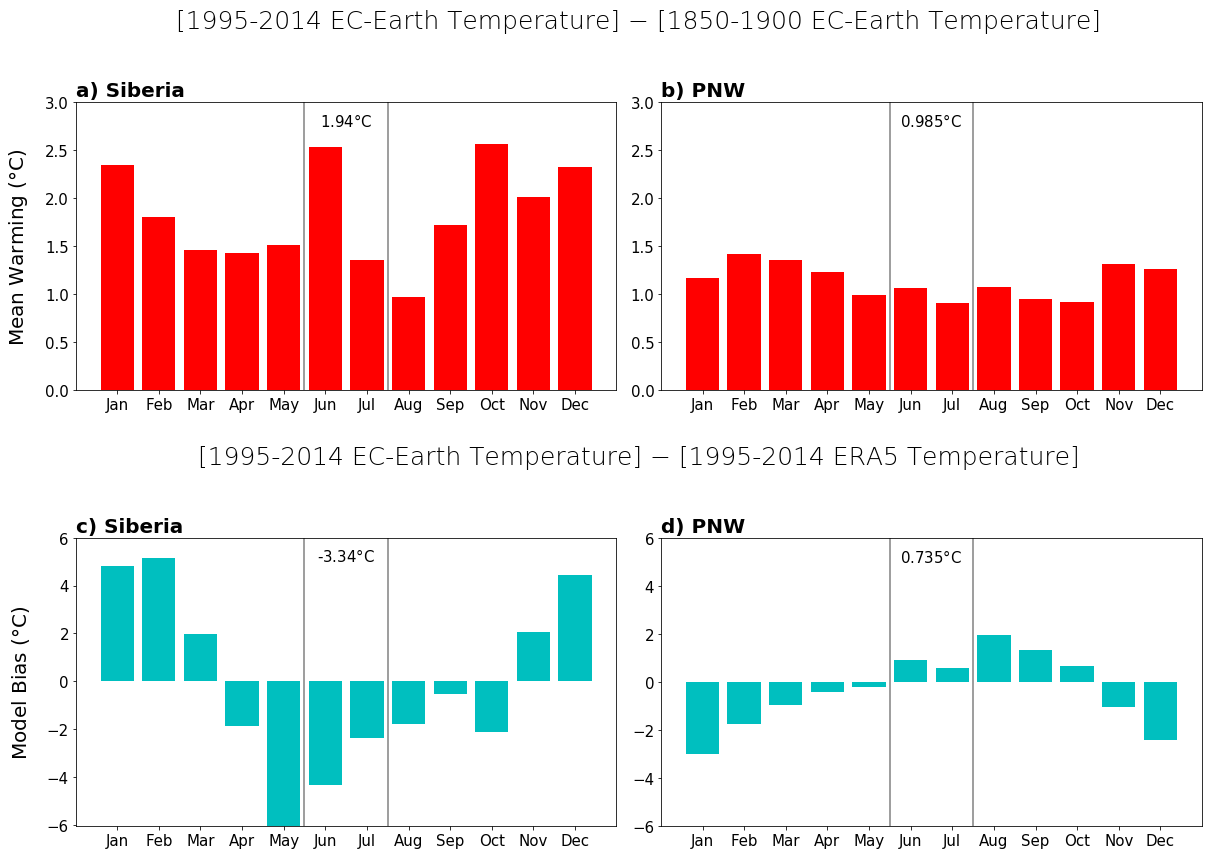

In [13]:
#plot graph
#df_final = pd.read_excel('Spreadsheets/Model_Validation.xlsx', index_col=0)  

month_list = [1,2,3,4,5,6,7,8,9,10,11,12]
month_strings = ['Jan', 'Feb', 'Mar','Apr', 'May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

#matplotlib
fig1 = plt.figure(figsize=(17,12))
#plt.rcParams['axes.titlepad'] = 20

fig1.patch.set_facecolor('w')

#position of stdv labels
y_max_value=3
y_max_value2=6

#grid
gs = gridspec.GridSpec(38,2)
#subtitles
ax0 = fig1.add_subplot(gs[0:3,:])
ax0.axis('off')
ax02 = fig1.add_subplot(gs[19:22,:])
ax02.axis('off')
ax0.text(0.5,0.5,'[1995-2014 EC-Earth Temperature] \N{MINUS SIGN} [1850-1900 EC-Earth Temperature]', fontsize=25, ha='center',fontweight = 'light')
ax02.text(0.5,0.5,'[1995-2014 EC-Earth Temperature] \N{MINUS SIGN} [1995-2014 ERA5 Temperature]', fontsize = 25, ha='center', fontweight='light')

#Siberia model
#ax1 = fig1.add_subplot(2,2,1)
ax1 = fig1.add_subplot(gs[4:18,0])

#ax1.plot(month_list,df_SIBR['Mean_Temp'], label = 'Reanalysis 1995-2014')
ax1.bar(month_list,df_SIBE-df_SIB_preInd, label = 'Modelled Warming', color='r')
#ax1.plot(month_list,df_SIB_preInd, label = 'Model 1850-1900')
#ax1.set_xticks(np.arange(0, 41, step=5))
ax1.set_ylabel('Mean Warming ($\degree$C)', fontsize=20, labelpad = 15)
#ax1.set_xlabel('Month', fontsize=20, labelpad = 15)
ax1.set_xticks(month_list)
ax1.set_xticklabels(month_strings)
ax1.set_yticks(np.arange(0,3.5, step=0.5))
ax1.tick_params(labelsize=15)
ax1.axvline(5.5, color='grey')
ax1.axvline(7.5, color='grey')
ax1.set_title('a) Siberia', size=20, fontweight='bold',loc='left')
#ax1.legend()

#PNW model
#ax2 = fig1.add_subplot(2,2,2)
ax2 = fig1.add_subplot(gs[4:18,1])
#ax2.plot(month_list,df_PNWR['Mean_Temp'], label = 'Reanalysis 1995-2014')
ax2.bar(month_list,df_PNWE-df_PNW_preInd, label = 'Modelled Warming', color='r')
#ax2.plot(month_list,df_PNW_preInd, label = 'Model 1850-1900')
#ax2.set_xticks(np.arange(0, 41, step=5))
#ax2.set_ylabel('Mean Temperature ($\degree$C)', fontsize=20, labelpad = 15)
#ax2.set_xlabel('Month', fontsize=20, labelpad = 15)
ax2.set_xticks(month_list)
ax2.set_xticklabels(month_strings)
ax2.set_yticks(np.arange(0,3.5, step=0.5))
ax2.tick_params(labelsize=15)
ax2.axvline(5.5, color='grey')
ax2.axvline(7.5, color='grey')
ax2.set_title('b) PNW', size=20, fontweight='bold',loc='left')
#ax2.legend()

#Siberia bias
#ax3 = fig1.add_subplot(2,2,3)
ax3 = fig1.add_subplot(gs[23:37,0])
ax3.bar(month_list,df_SIBE-df_SIBR['Mean_Temp'], label = 'Model bias', color='c')
ax3.set_ylabel('Model Bias ($\degree$C)', fontsize=20, labelpad = 15)
#ax3.set_xlabel('Month', fontsize=20, labelpad = 15)
ax3.set_xticks(month_list)
ax3.set_yticks(np.arange(-6,8, step=2))
ax3.set_xticklabels(month_strings)
ax3.tick_params(labelsize=15)
ax3.axvline(5.5, color='grey')
ax3.axvline(7.5, color='grey')
ax3.set_title('c) Siberia', size=20, fontweight='bold',loc='left')

#PNW model bias
#ax4 = fig1.add_subplot(2,2,4)
ax4 = fig1.add_subplot(gs[23:37,1])
ax4.bar(month_list,df_PNWE-df_PNWR['Mean_Temp'], label = 'Model bias', color='c')
ax4.set_xticks(month_list)
ax4.set_xticklabels(month_strings)
ax4.set_yticks(np.arange(-6,8, step=2))
ax4.tick_params(labelsize=15)
ax4.axvline(5.5, color='grey')
ax4.axvline(7.5, color='grey')
ax4.set_title('d) PNW', size=20, fontweight='bold',loc='left')


#mean JuneJuly temps labels
ax1.text(6.5, 2.75, r"1.94$\degree$C", fontsize=15, ha='center')
ax2.text(6.5, 2.75, r"0.985$\degree$C", fontsize=15, ha='center')
ax3.text(6.5, 5,r"-3.34$\degree$C", fontsize=15, ha='center')
ax4.text(6.5, 5,r"0.735$\degree$C", fontsize=15, ha='center')

#print(SIB_mean_warming)
#print(PNW_mean_warming)
#print(SIB_mean_bias)
#print(PNW_mean_bias)


plt.tight_layout()

plt.savefig('Model_validation_chart.png',format ='png', dpi=150, bbox_inches='tight')


plt.show()

In [155]:
print(SIB_mean_warming)
print(PNW_mean_warming)
print(SIB_mean_bias)
print(PNW_mean_bias)

1.9413203144344207
0.9848170525419953
-3.344810673815102
0.7346693578345311


In [8]:
#entire globe warming
#create empty lists
months =[]
mean_temps =[]
member =[]
years=[]

path = '/nfs/annie/earamay/Prash/historical/tas/'
#"/nfs/annie/earamay/Prash/historical/tas/tas_day_EC-Earth3_historical_r10i1p1f1_gr_19080101-19081231.nc"

for memberno in [1,2,3,4,6,7,9,10,12,14]:
#for memberno in [1]:
#for memberno in [10,12,14]:
    for year in np.arange(1850,1901,1):
        #files = glob.glob("/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        files = glob.glob(path + "tas_Amon_EC-Earth3_historical_r" +str(memberno)+ "i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        #files = glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc")
        for filename in files:
            #for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
                
            member_string = "r" +str(memberno)+ "i1p1f1"

            cube1 = iris.load_cube(filename)

            iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

            # Access the longitude and latitude coordinates
            longitude = cube1.coord('longitude')
            latitude = cube1.coord('latitude')
            time = cube1.coord('time')
            month = cube1.coord('month')

            def time_convert(input):
                return unit.num2date(input,'days since 1850-01-01 00:00:00', 'proleptic_gregorian')
            
            #convert units
            cube1.convert_units('celsius')
            
            coords = ('longitude', 'latitude')
            spatial_mean = cube1.collapsed(coords, iris.analysis.MEAN)

            #append time and max temps to lists
            months.extend(spatial_mean.coord('month').points)
            mean_temps.extend(spatial_mean.data)
            
            add_to_years = np.repeat(year,np.shape(spatial_mean))
            add_to_member = np.repeat(member_string,np.shape(spatial_mean))
            member.extend(add_to_member)
            years.extend(add_to_years)

#make dataframe
df = pd.DataFrame({
    'Month': months,
    'Year': years,
    'Mean_Temp': mean_temps,
    'Member': member,
})

df['Mean_Temp'] = df['Mean_Temp'].astype(float)
df_global_preInd = df.groupby('Month')['Mean_Temp'].mean()
df_global_preInd



Month
1     3.183671
2     3.055654
3     3.266439
4     4.380816
5     5.994181
6     7.502608
7     8.276001
8     7.953199
9     6.522674
10    4.788916
11    3.714049
12    3.280246
Name: Mean_Temp, dtype: float64

In [9]:
#entire globe warming
#create empty lists
months =[]
mean_temps =[]
member =[]
years=[]

path = '/nfs/annie/earamay/Prash/historical/tas/'
#"/nfs/annie/earamay/Prash/historical/tas/tas_day_EC-Earth3_historical_r10i1p1f1_gr_19080101-19081231.nc"

for memberno in [1,2,3,4,6,7,9,10,12,14]:
#for memberno in [1]:
#for memberno in [10,12,14]:
    for year in np.arange(1995,2015,1):
        #files = glob.glob("/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r1i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        files = glob.glob(path + "tas_Amon_EC-Earth3_historical_r" +str(memberno)+ "i1p1f1_gr_" +str(year)+ "01-" +str(year)+ "12.nc")
        #files = glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc")
        for filename in files:
            #for mon in [1,2,3,4,5,6,7,8,9,10,11,12]:
                
            member_string = "r" +str(memberno)+ "i1p1f1"

            cube1 = iris.load_cube(filename)

            iris.coord_categorisation.add_month_number(cube1, 'time', name='month')

            # Access the longitude and latitude coordinates
            longitude = cube1.coord('longitude')
            latitude = cube1.coord('latitude')
            time = cube1.coord('time')
            month = cube1.coord('month')

            def time_convert(input):
                return unit.num2date(input,'days since 1850-01-01 00:00:00', 'proleptic_gregorian')
            
            #convert units
            cube1.convert_units('celsius')
            
            coords = ('longitude', 'latitude')
            spatial_mean = cube1.collapsed(coords, iris.analysis.MEAN)

            #append time and max temps to lists
            months.extend(spatial_mean.coord('month').points)
            mean_temps.extend(spatial_mean.data)
            
            add_to_years = np.repeat(year,np.shape(spatial_mean))
            add_to_member = np.repeat(member_string,np.shape(spatial_mean))
            member.extend(add_to_member)
            years.extend(add_to_years)

#make dataframe
df = pd.DataFrame({
    'Month': months,
    'Year': years,
    'Mean_Temp': mean_temps,
    'Member': member,
})

df['Mean_Temp'] = df['Mean_Temp'].astype(float)
df_global = df.groupby('Month')['Mean_Temp'].mean()
df_global

Month
1     4.473334
2     4.324041
3     4.477378
4     5.540566
5     7.127436
6     8.588303
7     9.292737
8     9.014456
9     7.809352
10    6.203230
11    5.152106
12    4.639644
Name: Mean_Temp, dtype: float64

In [141]:
#find average global warming
globe_mean_warming = np.mean(df_global-df_global_preInd)

print(globe_mean_warming)

1.2270106449898552


In [10]:
mean_now = np.mean(df_global)
mean_preInd = np.mean(df_global_preInd)

mean_warming = mean_now - mean_preInd

print(mean_warming)

1.2270106449898561


In [101]:
#check which members have data

for memberno in [1,2,3,4,6,7,9,10,12,14]:
    files2 =[]
    for year in np.arange(1995,2015,1):
        files2.append(glob.glob(path + "*_r" +str(memberno)+ "i1p1f1_gr_"+str(year)+ "*.nc"))
        
   # print(str(memberno)+ "i1p1f1", files2)
    
    
    #2,4,7,10,12,14 are empty
    #for memberno in [1,3,6,9]:

In [111]:
list1 = glob.glob(path + "*_Amon*185012.nc")

for file in list1:
    print(file[70:])

r10i1p1f1_gr_185001-185012.nc
r12i1p1f1_gr_185001-185012.nc
r14i1p1f1_gr_185001-185012.nc
r1i1p1f1_gr_185001-185012.nc
r2i1p1f1_gr_185001-185012.nc
r3i1p1f1_gr_185001-185012.nc
r4i1p1f1_gr_185001-185012.nc
r6i1p1f1_gr_185001-185012.nc
r7i1p1f1_gr_185001-185012.nc
r9i1p1f1_gr_185001-185012.nc


print(list1[1])

In [113]:
print(list1[1])

/nfs/annie/earamay/Prash/historical/tas/tas_Amon_EC-Earth3_historical_r12i1p1f1_gr_185001-185012.nc
